In [7]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
import numpy as np

In [9]:
# Loading the dataset

df = pd.read_csv('Apache_2k_modified.csv')

In [11]:
df.head()

,LineId,Time,Level,Content,EventId,EventTemplate
0,1,Sun Dec 04 04:47:44 2005,notice,workerEnv.init() ok /etc/httpd/conf/workers2.p...,workerEnv.init\(\) ok <*>,workerEnv.init() ok <*>
1,2,Sun Dec 04 04:47:44 2005,error,mod_jk child workerEnv in error state 6,mod_jk child workerEnv in error state <*>,mod_jk child workerEnv in error state <*>
2,3,Sun Dec 04 04:51:08 2005,notice,jk2_init() Found child 6725 in scoreboard slot 10,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>
3,4,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6726 in scoreboard slot 8,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>
4,5,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6728 in scoreboard slot 6,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>


In [12]:
df.isnull().sum()

LineId           0
Time             0
Level            0
Content          0
EventId          0
EventTemplate    0
dtype: int64

In [15]:
len(df)

2000

In [21]:
df = df.drop_duplicates()

In [22]:
len(df)

2000

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [24]:
label_encoder = LabelEncoder()
df['Level_encoded'] = label_encoder.fit_transform(df['Level'])

In [25]:
tfidf = TfidfVectorizer(max_features=100)
content_tfidf = tfidf.fit_transform(df['Content']).toarray()
X = np.hstack((df[['Level_encoded']].values, content_tfidf))

In [26]:
# Bagging with multiple anomaly detectors

iso_forest = IsolationForest(contamination=0.05, random_state=42)
lof = LocalOutlierFactor(n_neighbors=20)
ocsvm = OneClassSVM(kernel='rbf', nu=0.05)

In [27]:
# Predicting Anomalies

iso_pred = iso_forest.fit_predict(X)
lof_pred = lof.fit_predict(X)
ocsvm_pred = ocsvm.fit_predict(X)

/home/kairaj5456/.local/bin/new/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [29]:
# Majority Voting for Final Decision

final_pred = np.sign(iso_pred + lof_pred + ocsvm_pred)
final_pred[final_pred > 0] = 1   # Majority is normal
final_pred[final_pred <=0] = -1  # Majority is anomaly

In [33]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Apply DBSCAN for clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# DBSCAN outliers are labeled as -1
dbscan_outliers = np.where(dbscan_labels == -1)[0]  # Indices of outliers in DBSCAN

# Compare DBSCAN outliers with the anomalies detected by the ensemble model
ensemble_outliers = np.where(final_pred == -1)[0]  # Indices of outliers in ensemble model

# Calculate the intersection of DBSCAN outliers and ensemble model outliers
intersection = np.intersect1d(dbscan_outliers, ensemble_outliers)

# Calculate the Jaccard similarity index between DBSCAN and ensemble model outliers
jaccard_index = len(intersection) / (len(dbscan_outliers) + len(ensemble_outliers) - len(intersection))

# Evaluate the clustering quality using Silhouette Score
sil_score = silhouette_score(X, dbscan_labels)

# Print the results
print(f"Number of DBSCAN Outliers: {len(dbscan_outliers)}")
print(f"Number of Ensemble Model Outliers: {len(ensemble_outliers)}")
print(f"Number of Common Outliers (Intersection): {len(intersection)}")
print(f"Jaccard Index: {jaccard_index:.4f}")
print(f"Silhouette Score for DBSCAN: {sil_score:.4f}")

Number of DBSCAN Outliers: 77
Number of Ensemble Model Outliers: 116
Number of Common Outliers (Intersection): 67
Jaccard Index: 0.5317
Silhouette Score for DBSCAN: 0.9553


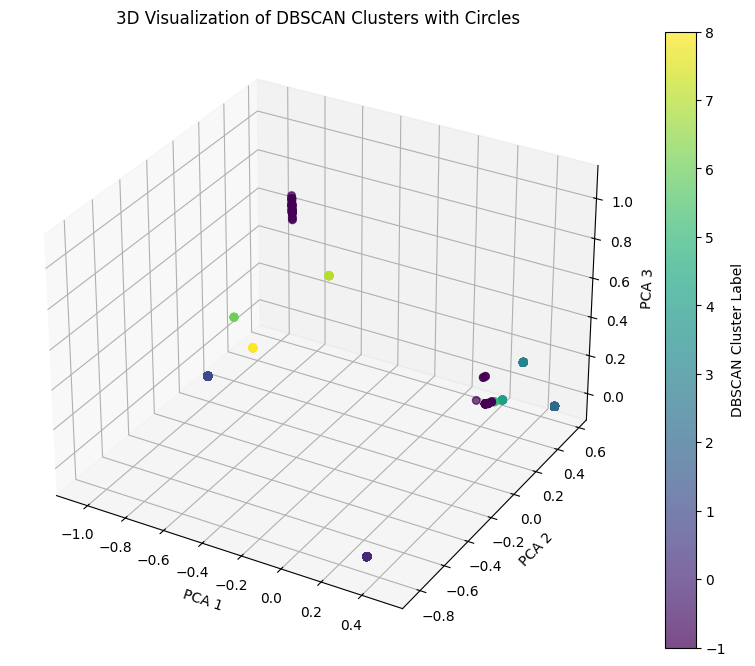

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist

# Apply DBSCAN for clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Perform PCA to reduce the dimensionality of the data to 3 components for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points, using the DBSCAN labels to color them
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=dbscan_labels, cmap='viridis', s=30, alpha=0.7)

# Add color bar to indicate different clusters
cbar = plt.colorbar(scatter)
cbar.set_label('DBSCAN Cluster Label')

# Plot circles around clusters
unique_labels = np.unique(dbscan_labels)
for label in unique_labels:
    if label == -1:
        continue  # Skip outliers (label = -1)
    
    # Get points in the current cluster
    cluster_points = X_pca[dbscan_labels == label]
    
    # Compute the centroid of the cluster
    centroid = np.mean(cluster_points, axis=0)
    
    # Compute the radius of the circle (e.g., based on the standard deviation of the points)
    distances = cdist(cluster_points, [centroid])
    radius = np.max(distances)  # Maximum distance from centroid (for a larger circle)
    
    # Plot a sphere around the centroid
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = centroid[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = centroid[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = centroid[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    
    ax.plot_surface(x, y, z, color='r', alpha=0.3)  # Red circle for each cluster

# Add labels to axes
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

# Title of the plot
ax.set_title('3D Visualization of DBSCAN Clusters with Circles')

# Show the plot
plt.show()


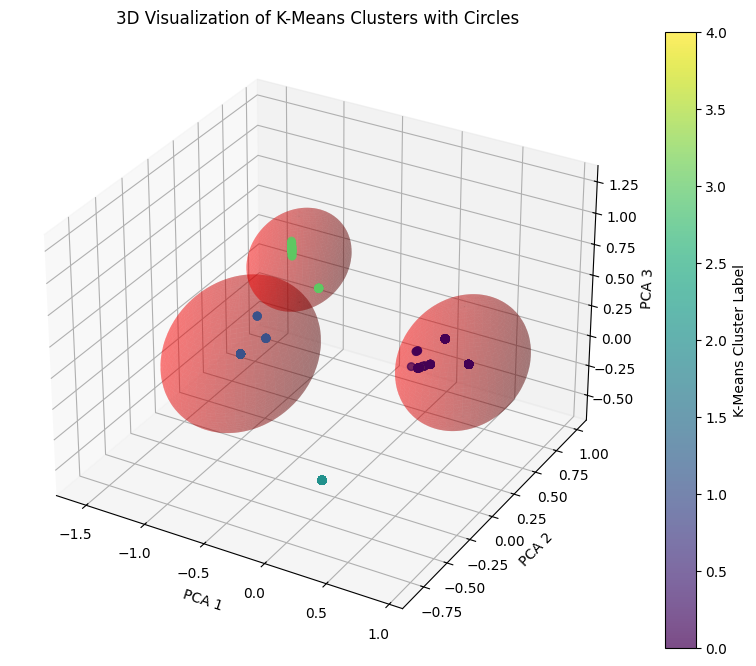

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist


# Apply K-Means for clustering (you can adjust the number of clusters here)
num_clusters = 5  # Adjust based on your data or use Elbow/Silhouette to determine the optimal value
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Perform PCA to reduce the dimensionality of the data to 3 components for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points, using the KMeans labels to color them
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans_labels, cmap='viridis', s=30, alpha=0.7)

# Add color bar to indicate different clusters
cbar = plt.colorbar(scatter)
cbar.set_label('K-Means Cluster Label')

# Plot circles around clusters
for label in range(num_clusters):
    # Get points in the current cluster
    cluster_points = X_pca[kmeans_labels == label]
    
    # Compute the centroid of the cluster
    centroid = np.mean(cluster_points, axis=0)
    
    # Compute the radius of the circle (e.g., based on the standard deviation of the points)
    distances = cdist(cluster_points, [centroid])
    radius = np.max(distances)  # Maximum distance from centroid (for a larger circle)
    
    # Plot a sphere around the centroid
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = centroid[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = centroid[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = centroid[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    
    ax.plot_surface(x, y, z, color='r', alpha=0.3)  # Red circle for each cluster

# Add labels to axes
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

# Title of the plot
ax.set_title('3D Visualization of K-Means Clusters with Circles')

# Show the plot
plt.show()